# Analysis Overview

**Author**: Clarence Mah<br>
**Email**: ckmah@ucsd.edu

TODO: citation

This analysis aims to classify additional SHHa/SHHb type tumors, as done to classify additional Group 3 tumors in the "Group 3 Cohort Expansion" analysis of the paper: Proteomics, post-translational modifications, and integrative analyses reveal heterogeneity of molecular mechanisms within medulloblastoma subgroups. Archer et al. (2018).

To expand our number of SHHa/SHHb type tumors (typed with proteomics-based clustering), we used the c3 samples from the Cho et al. (2011) cohort which are most like SHH. Since only array data were available for the Cho samples, we also used array data for our current SHH cohort to better normalize the two data sets.

Following the methods in Cho et al. (2011), we projected the expression data for both cohorts into “gene set space” using a single sample version of GSEA (ssGSEA), using the Hallmarks (H), Curated Gene
Sets (C2), Motif Gene Sets (C3), and Oncogenic Gene Sets (C6) collections from the MSigDB. Using the SHHa, SHHb labels for the current cohort, we determined the 10 most differentially enriched gene sets for each subtype (Figure S5D, main text) according to the Information Coefficient (IC) as defined in Kim et al. (2016). These top sets were used as features to train a Bayesian cumulative log-odds predictor as previously described (Tamayo et al., 2011). The predictor was applied to the projected Cho et al. (2011) c3 samples to assign SHHa and SHHb labels.

# Notebook Setup

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sys
import os

sys.path.append('../scripts/')
sys.setrecursionlimit(40000)

from rpy2.robjects import pandas2ri
pandas2ri.activate()

%matplotlib inline

Functions for rpy2 interface to the bayesian classifier.

In [2]:
def apply_bayesian_classifier(train_features, train_target, train_dir, test_features, out_dir, run_train=True):
    '''
    Apply a Bayesian predictor for continuous (via discretization), binary or multi-class targets.

    train_features : str
        Path to dataset with features as rows and samples as columns.

    train_target : str
        Path to training dataset category labels.

    train_dir : str
        Path to training model folder.

    test_features : str
        Path to testing dataset with features as rows and samples as columns.

    out_dir : str
        Path to save testing data classification files.

    run_train : bool
        True to perform training step, False to skip.
    '''
    command = 'Rscript ../scripts/apply_bayesian_classifier.R {} {} {} {} {} {}'.format(
        train_features,
        train_target,
        train_dir,
        test_features,
        out_dir,
        run_train)

    os.system(command)
    probs_file = os.path.join(out_dir, 'test_output.gct')
    probs_df = pd.read_table(probs_file, skiprows=2)
    return probs_df

# Apply bayesian classifier

Use top 10 differentially enriched pathways of training data (Fraenkel SHHa/b samples). Total 20 features.

NOTE: Step may be slow and will try to install required R packages as necessary.

In [3]:
train_features = '../data/fraenkel/affy_norm.msigdb.v6.0.h.c2.c3.c6.PROJ.shha_shhb.top_10.gct'
train_target = '../data/fraenkel/shhab.subtypes.verbose.gct'
train_dir = '../data/fraenkel/shhab_affy_no_go_train/'

# TODO: change files to fit your test dataset
test_features = '../data/cho/cho.fraenkel_affy.v6.0.h.c2.c3.c6.proj.shha_shhb.top_10.gct'
out_dir = '../data/cho/cho_shhab_affy_no_go_test/'

test_prob = apply_bayesian_classifier(train_features, train_target, train_dir, test_features, out_dir)

Load test results.

In [4]:
# TODO: change files to fit your test dataset
test_prob = pd.read_table('../data/cho/cho_shhab_affy_no_go_test/test_output.gct', skiprows=2, index_col='Name')
test_prob.drop('Description', axis=1, inplace=True)
test_labels = test_prob.loc['predicted.model']
test_labels.replace(to_replace='SHHa', value='A', inplace=True)
test_labels.replace(to_replace='SHHb', value='B', inplace=True)

# Evaluate Results

Load test data c1/c5 labels to compare to predicted G3a/b labels.

In [5]:
colors = {'G3b': '#F68B1F',
          'G3a': '#ECE81B',
          'G4': '#6E8C3D',
          'SHHa': '#E72A2D',
          'SHHb': '#714A9E'}

In [6]:
# TODO: change files to fit your test dataset
cho_c_labels = pd.read_table('../data/cho/primaries.subtypes.tsv', index_col=0, header=None).iloc[:,0]
cho_c_labels = cho_c_labels.loc[(cho_c_labels == 'c3')]

annotations = pd.DataFrame([test_labels, cho_c_labels]).T
annotations = annotations.apply(lambda x: pd.factorize(x)[0])
annotations.replace([0,1], [colors['SHHa'], colors['SHHb']], inplace=True)
annotations.columns = ['predicted', 'c']

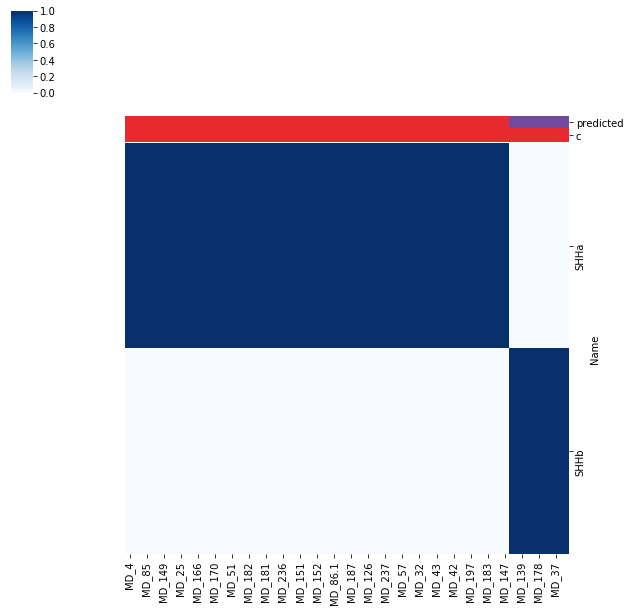

In [7]:
sns.clustermap(
    test_prob.iloc[:2, :].astype(float),
    cmap='Blues',
    col_cluster=False,
    row_cluster=False,
    col_colors=annotations)